<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:14:58] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


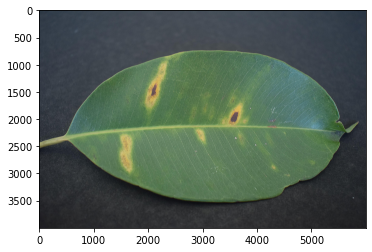

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

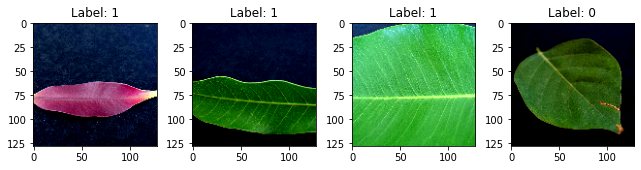

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:15:04] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:15:06] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2559701984724778 samples/sec                   batch loss = 1.212082862854004 | accuracy = 0.3


Epoch[1] Batch[10] Speed: 1.2570943204974543 samples/sec                   batch loss = 1.2981657981872559 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.243069165457659 samples/sec                   batch loss = 1.342020034790039 | accuracy = 0.45


Epoch[1] Batch[20] Speed: 1.2726430180268167 samples/sec                   batch loss = 0.8141303658485413 | accuracy = 0.4625


Epoch[1] Batch[25] Speed: 1.2677692648838934 samples/sec                   batch loss = 0.6316067576408386 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.2599268370198191 samples/sec                   batch loss = 0.5353747606277466 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2642065806165272 samples/sec                   batch loss = 0.7393776178359985 | accuracy = 0.5857142857142857


Epoch[1] Batch[40] Speed: 1.2674902640896837 samples/sec                   batch loss = 0.8846222758293152 | accuracy = 0.59375


Epoch[1] Batch[45] Speed: 1.2714666459722226 samples/sec                   batch loss = 0.473283588886261 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.2703180312345657 samples/sec                   batch loss = 0.14719773828983307 | accuracy = 0.625


Epoch[1] Batch[55] Speed: 1.266663465507968 samples/sec                   batch loss = 0.6265993714332581 | accuracy = 0.6363636363636364


Epoch[1] Batch[60] Speed: 1.2639709482537995 samples/sec                   batch loss = 0.2685343027114868 | accuracy = 0.6541666666666667


Epoch[1] Batch[65] Speed: 1.2703921938028497 samples/sec                   batch loss = 0.7988379001617432 | accuracy = 0.6538461538461539


Epoch[1] Batch[70] Speed: 1.272657402185966 samples/sec                   batch loss = 0.29261350631713867 | accuracy = 0.6571428571428571


Epoch[1] Batch[75] Speed: 1.2640969444464536 samples/sec                   batch loss = 1.223550796508789 | accuracy = 0.6533333333333333


Epoch[1] Batch[80] Speed: 1.2632889289138995 samples/sec                   batch loss = 0.8408905267715454 | accuracy = 0.65625


Epoch[1] Batch[85] Speed: 1.2658071833123539 samples/sec                   batch loss = 0.6156941652297974 | accuracy = 0.6647058823529411


Epoch[1] Batch[90] Speed: 1.2687501417938778 samples/sec                   batch loss = 0.9419800639152527 | accuracy = 0.6611111111111111


Epoch[1] Batch[95] Speed: 1.2619972442072012 samples/sec                   batch loss = 0.532336950302124 | accuracy = 0.6578947368421053


Epoch[1] Batch[100] Speed: 1.2587203921857255 samples/sec                   batch loss = 0.8816589117050171 | accuracy = 0.6575


Epoch[1] Batch[105] Speed: 1.2665982479390205 samples/sec                   batch loss = 0.3943514823913574 | accuracy = 0.65


Epoch[1] Batch[110] Speed: 1.261795458346921 samples/sec                   batch loss = 0.33005720376968384 | accuracy = 0.6522727272727272


Epoch[1] Batch[115] Speed: 1.262043191305592 samples/sec                   batch loss = 0.4516342580318451 | accuracy = 0.6565217391304348


Epoch[1] Batch[120] Speed: 1.2656580258221994 samples/sec                   batch loss = 0.2795451879501343 | accuracy = 0.6604166666666667


Epoch[1] Batch[125] Speed: 1.263093481416345 samples/sec                   batch loss = 0.5467205047607422 | accuracy = 0.662


Epoch[1] Batch[130] Speed: 1.267227370610704 samples/sec                   batch loss = 0.5251427292823792 | accuracy = 0.6615384615384615


Epoch[1] Batch[135] Speed: 1.2638383127384403 samples/sec                   batch loss = 0.30881625413894653 | accuracy = 0.6574074074074074


Epoch[1] Batch[140] Speed: 1.2673933656735947 samples/sec                   batch loss = 0.3010872006416321 | accuracy = 0.6571428571428571


Epoch[1] Batch[145] Speed: 1.26209151531405 samples/sec                   batch loss = 1.0831457376480103 | accuracy = 0.653448275862069


Epoch[1] Batch[150] Speed: 1.2547995633649915 samples/sec                   batch loss = 0.7572254538536072 | accuracy = 0.655


Epoch[1] Batch[155] Speed: 1.2604585269255855 samples/sec                   batch loss = 0.48392289876937866 | accuracy = 0.6548387096774193


Epoch[1] Batch[160] Speed: 1.2665973873415122 samples/sec                   batch loss = 0.1782190054655075 | accuracy = 0.6546875


Epoch[1] Batch[165] Speed: 1.2669260293726414 samples/sec                   batch loss = 0.3065239489078522 | accuracy = 0.6575757575757576


Epoch[1] Batch[170] Speed: 1.2630890120349896 samples/sec                   batch loss = 0.31227242946624756 | accuracy = 0.6617647058823529


Epoch[1] Batch[175] Speed: 1.2584747170756176 samples/sec                   batch loss = 0.6984872221946716 | accuracy = 0.6571428571428571


Epoch[1] Batch[180] Speed: 1.261553134863159 samples/sec                   batch loss = 0.9644455313682556 | accuracy = 0.6611111111111111


Epoch[1] Batch[185] Speed: 1.2676276899152248 samples/sec                   batch loss = 0.2058708518743515 | accuracy = 0.6662162162162162


Epoch[1] Batch[190] Speed: 1.2656542066297791 samples/sec                   batch loss = 0.8467976450920105 | accuracy = 0.6644736842105263


Epoch[1] Batch[195] Speed: 1.2575843118583045 samples/sec                   batch loss = 0.5263692736625671 | accuracy = 0.6653846153846154


Epoch[1] Batch[200] Speed: 1.2584810418651653 samples/sec                   batch loss = 0.33014288544654846 | accuracy = 0.6725


Epoch[1] Batch[205] Speed: 1.2610519895945196 samples/sec                   batch loss = 0.6748929619789124 | accuracy = 0.6707317073170732


Epoch[1] Batch[210] Speed: 1.2593765937172952 samples/sec                   batch loss = 0.5680925846099854 | accuracy = 0.6678571428571428


Epoch[1] Batch[215] Speed: 1.2705651772535638 samples/sec                   batch loss = 0.3446989059448242 | accuracy = 0.6709302325581395


Epoch[1] Batch[220] Speed: 1.2643402462571804 samples/sec                   batch loss = 0.5970289707183838 | accuracy = 0.6704545454545454


Epoch[1] Batch[225] Speed: 1.2630466020328186 samples/sec                   batch loss = 0.6452640295028687 | accuracy = 0.6722222222222223


Epoch[1] Batch[230] Speed: 1.2647013705139845 samples/sec                   batch loss = 0.41700682044029236 | accuracy = 0.6760869565217391


Epoch[1] Batch[235] Speed: 1.2704552051228286 samples/sec                   batch loss = 0.44415774941444397 | accuracy = 0.6787234042553192


Epoch[1] Batch[240] Speed: 1.270049925483844 samples/sec                   batch loss = 0.45965903997421265 | accuracy = 0.678125


Epoch[1] Batch[245] Speed: 1.2524954962776869 samples/sec                   batch loss = 1.200217843055725 | accuracy = 0.6785714285714286


Epoch[1] Batch[250] Speed: 1.262210394831211 samples/sec                   batch loss = 0.8071683645248413 | accuracy = 0.681


Epoch[1] Batch[255] Speed: 1.2658950518076932 samples/sec                   batch loss = 0.27252402901649475 | accuracy = 0.6823529411764706


Epoch[1] Batch[260] Speed: 1.2591641155230864 samples/sec                   batch loss = 0.6026827692985535 | accuracy = 0.6817307692307693


Epoch[1] Batch[265] Speed: 1.2675246416929928 samples/sec                   batch loss = 0.31440719962120056 | accuracy = 0.680188679245283


Epoch[1] Batch[270] Speed: 1.2568114302220565 samples/sec                   batch loss = 0.7583989500999451 | accuracy = 0.6805555555555556


Epoch[1] Batch[275] Speed: 1.2557286972339894 samples/sec                   batch loss = 0.5106943249702454 | accuracy = 0.6790909090909091


Epoch[1] Batch[280] Speed: 1.2662418693857798 samples/sec                   batch loss = 0.7657391428947449 | accuracy = 0.675


Epoch[1] Batch[285] Speed: 1.261976360268438 samples/sec                   batch loss = 0.48111259937286377 | accuracy = 0.6763157894736842


Epoch[1] Batch[290] Speed: 1.2649468125251118 samples/sec                   batch loss = 0.496684193611145 | accuracy = 0.6758620689655173


Epoch[1] Batch[295] Speed: 1.2540664695257997 samples/sec                   batch loss = 0.35609421133995056 | accuracy = 0.6779661016949152


Epoch[1] Batch[300] Speed: 1.263135228867565 samples/sec                   batch loss = 0.4910888969898224 | accuracy = 0.6775


Epoch[1] Batch[305] Speed: 1.2656607947511171 samples/sec                   batch loss = 0.6568365693092346 | accuracy = 0.6770491803278689


Epoch[1] Batch[310] Speed: 1.2601031337986675 samples/sec                   batch loss = 0.3881847560405731 | accuracy = 0.6766129032258065


Epoch[1] Batch[315] Speed: 1.263443903270709 samples/sec                   batch loss = 0.8168724179267883 | accuracy = 0.6761904761904762


Epoch[1] Batch[320] Speed: 1.2566143110326424 samples/sec                   batch loss = 0.5053360462188721 | accuracy = 0.678125


Epoch[1] Batch[325] Speed: 1.2568666987053547 samples/sec                   batch loss = 1.3530724048614502 | accuracy = 0.6761538461538461


Epoch[1] Batch[330] Speed: 1.2637382594261481 samples/sec                   batch loss = 0.7924826741218567 | accuracy = 0.6765151515151515


Epoch[1] Batch[335] Speed: 1.2576419109224386 samples/sec                   batch loss = 0.6527501940727234 | accuracy = 0.6753731343283582


Epoch[1] Batch[340] Speed: 1.253123974618759 samples/sec                   batch loss = 0.7121406197547913 | accuracy = 0.6772058823529412


Epoch[1] Batch[345] Speed: 1.259411383455014 samples/sec                   batch loss = 0.708808422088623 | accuracy = 0.6768115942028986


Epoch[1] Batch[350] Speed: 1.2725951375309696 samples/sec                   batch loss = 0.4673883616924286 | accuracy = 0.6771428571428572


Epoch[1] Batch[355] Speed: 1.274115168898776 samples/sec                   batch loss = 0.6165912747383118 | accuracy = 0.6746478873239437


Epoch[1] Batch[360] Speed: 1.2651109704528718 samples/sec                   batch loss = 0.4606492817401886 | accuracy = 0.6736111111111112


Epoch[1] Batch[365] Speed: 1.2654146938421476 samples/sec                   batch loss = 0.6010453701019287 | accuracy = 0.6732876712328767


Epoch[1] Batch[370] Speed: 1.2639560932152791 samples/sec                   batch loss = 0.6069979667663574 | accuracy = 0.668918918918919


Epoch[1] Batch[375] Speed: 1.266690625537942 samples/sec                   batch loss = 0.3966065049171448 | accuracy = 0.67


Epoch[1] Batch[380] Speed: 1.2654427548206624 samples/sec                   batch loss = 0.48169466853141785 | accuracy = 0.6684210526315789


Epoch[1] Batch[385] Speed: 1.2719774548177847 samples/sec                   batch loss = 0.6259215474128723 | accuracy = 0.6701298701298701


Epoch[1] Batch[390] Speed: 1.260596800032339 samples/sec                   batch loss = 0.7601378560066223 | accuracy = 0.6711538461538461


Epoch[1] Batch[395] Speed: 1.2620586659782116 samples/sec                   batch loss = 0.568726122379303 | accuracy = 0.6689873417721519


Epoch[1] Batch[400] Speed: 1.2647771670291004 samples/sec                   batch loss = 0.278840571641922 | accuracy = 0.67


Epoch[1] Batch[405] Speed: 1.269157184421211 samples/sec                   batch loss = 0.4228859841823578 | accuracy = 0.6722222222222223


Epoch[1] Batch[410] Speed: 1.2605820241980246 samples/sec                   batch loss = 0.6524104475975037 | accuracy = 0.6719512195121952


Epoch[1] Batch[415] Speed: 1.2547650279493312 samples/sec                   batch loss = 0.7746641635894775 | accuracy = 0.6734939759036145


Epoch[1] Batch[420] Speed: 1.2582169651990533 samples/sec                   batch loss = 1.5503922700881958 | accuracy = 0.674404761904762


Epoch[1] Batch[425] Speed: 1.2610671556029498 samples/sec                   batch loss = 0.5206068754196167 | accuracy = 0.6747058823529412


Epoch[1] Batch[430] Speed: 1.2653355762199316 samples/sec                   batch loss = 0.32396063208580017 | accuracy = 0.6738372093023256


Epoch[1] Batch[435] Speed: 1.2650055649123024 samples/sec                   batch loss = 0.6209179162979126 | accuracy = 0.6741379310344827


Epoch[1] Batch[440] Speed: 1.2533850748017037 samples/sec                   batch loss = 0.5096961259841919 | accuracy = 0.6738636363636363


Epoch[1] Batch[445] Speed: 1.2609369293886665 samples/sec                   batch loss = 0.5726959109306335 | accuracy = 0.6747191011235955


Epoch[1] Batch[450] Speed: 1.2680642983538428 samples/sec                   batch loss = 0.6656758189201355 | accuracy = 0.675


Epoch[1] Batch[455] Speed: 1.2657267752274122 samples/sec                   batch loss = 0.1811600774526596 | accuracy = 0.6758241758241759


Epoch[1] Batch[460] Speed: 1.2629928804463937 samples/sec                   batch loss = 0.31940755248069763 | accuracy = 0.6766304347826086


Epoch[1] Batch[465] Speed: 1.2569404289680095 samples/sec                   batch loss = 0.37135276198387146 | accuracy = 0.6763440860215054


Epoch[1] Batch[470] Speed: 1.2605180942912797 samples/sec                   batch loss = 0.6764686107635498 | accuracy = 0.676063829787234


Epoch[1] Batch[475] Speed: 1.2591161099194137 samples/sec                   batch loss = 0.12577341496944427 | accuracy = 0.6773684210526316


Epoch[1] Batch[480] Speed: 1.2623910358072152 samples/sec                   batch loss = 0.15721780061721802 | accuracy = 0.6776041666666667


Epoch[1] Batch[485] Speed: 1.2565703583085555 samples/sec                   batch loss = 0.6603373289108276 | accuracy = 0.6778350515463918


Epoch[1] Batch[490] Speed: 1.2631235316952063 samples/sec                   batch loss = 0.40364402532577515 | accuracy = 0.6790816326530612


Epoch[1] Batch[495] Speed: 1.2631269552354234 samples/sec                   batch loss = 0.4431237280368805 | accuracy = 0.6797979797979798


Epoch[1] Batch[500] Speed: 1.2659622030220468 samples/sec                   batch loss = 1.059533715248108 | accuracy = 0.6795


Epoch[1] Batch[505] Speed: 1.2671897549363456 samples/sec                   batch loss = 1.1847540140151978 | accuracy = 0.6801980198019802


Epoch[1] Batch[510] Speed: 1.25900678798312 samples/sec                   batch loss = 0.6159307956695557 | accuracy = 0.6799019607843138


Epoch[1] Batch[515] Speed: 1.2610289569169144 samples/sec                   batch loss = 0.5149526596069336 | accuracy = 0.6810679611650485


Epoch[1] Batch[520] Speed: 1.2640858009135327 samples/sec                   batch loss = 0.62373948097229 | accuracy = 0.6807692307692308


Epoch[1] Batch[525] Speed: 1.2666154601347788 samples/sec                   batch loss = 0.5184979438781738 | accuracy = 0.6814285714285714


Epoch[1] Batch[530] Speed: 1.266100348688165 samples/sec                   batch loss = 0.3377021253108978 | accuracy = 0.6811320754716981


Epoch[1] Batch[535] Speed: 1.2525340213110951 samples/sec                   batch loss = 0.4318307936191559 | accuracy = 0.680841121495327


Epoch[1] Batch[540] Speed: 1.2590263454831276 samples/sec                   batch loss = 1.0842007398605347 | accuracy = 0.6810185185185185


Epoch[1] Batch[545] Speed: 1.2660148400353457 samples/sec                   batch loss = 0.6159620881080627 | accuracy = 0.6798165137614679


Epoch[1] Batch[550] Speed: 1.2691446073963013 samples/sec                   batch loss = 0.5473355650901794 | accuracy = 0.68


Epoch[1] Batch[555] Speed: 1.2636769596099335 samples/sec                   batch loss = 0.3444826900959015 | accuracy = 0.6797297297297298


Epoch[1] Batch[560] Speed: 1.2607313139398477 samples/sec                   batch loss = 0.5167902708053589 | accuracy = 0.6799107142857143


Epoch[1] Batch[565] Speed: 1.2612010114435774 samples/sec                   batch loss = 0.6720463037490845 | accuracy = 0.6800884955752212


Epoch[1] Batch[570] Speed: 1.2649110487279653 samples/sec                   batch loss = 0.27492883801460266 | accuracy = 0.6807017543859649


Epoch[1] Batch[575] Speed: 1.270254841170597 samples/sec                   batch loss = 0.2802464962005615 | accuracy = 0.6808695652173913


Epoch[1] Batch[580] Speed: 1.2614953666940187 samples/sec                   batch loss = 0.6458728313446045 | accuracy = 0.6814655172413793


Epoch[1] Batch[585] Speed: 1.2545481927395519 samples/sec                   batch loss = 0.5299065709114075 | accuracy = 0.6824786324786325


Epoch[1] Batch[590] Speed: 1.2705267858691252 samples/sec                   batch loss = 0.7243970632553101 | accuracy = 0.6809322033898305


Epoch[1] Batch[595] Speed: 1.261481992551961 samples/sec                   batch loss = 0.22142812609672546 | accuracy = 0.6815126050420168


Epoch[1] Batch[600] Speed: 1.260806161570639 samples/sec                   batch loss = 0.36627137660980225 | accuracy = 0.6820833333333334


Epoch[1] Batch[605] Speed: 1.2689791131313934 samples/sec                   batch loss = 0.4995707869529724 | accuracy = 0.6818181818181818


Epoch[1] Batch[610] Speed: 1.2586054737868047 samples/sec                   batch loss = 1.2663713693618774 | accuracy = 0.6815573770491803


Epoch[1] Batch[615] Speed: 1.2669311956551699 samples/sec                   batch loss = 0.11391539126634598 | accuracy = 0.6833333333333333


Epoch[1] Batch[620] Speed: 1.2715002759795342 samples/sec                   batch loss = 0.20885907113552094 | accuracy = 0.6842741935483871


Epoch[1] Batch[625] Speed: 1.270306873932165 samples/sec                   batch loss = 0.7081206440925598 | accuracy = 0.684


Epoch[1] Batch[630] Speed: 1.2612652950974723 samples/sec                   batch loss = 0.2959493398666382 | accuracy = 0.6853174603174603


Epoch[1] Batch[635] Speed: 1.2635660829699664 samples/sec                   batch loss = 0.5413686633110046 | accuracy = 0.6862204724409449


Epoch[1] Batch[640] Speed: 1.2681191232048374 samples/sec                   batch loss = 0.44899457693099976 | accuracy = 0.68671875


Epoch[1] Batch[645] Speed: 1.26439046153765 samples/sec                   batch loss = 0.3989361822605133 | accuracy = 0.6868217054263566


Epoch[1] Batch[650] Speed: 1.2597943866621653 samples/sec                   batch loss = 0.4538758099079132 | accuracy = 0.6873076923076923


Epoch[1] Batch[655] Speed: 1.2576280527277965 samples/sec                   batch loss = 0.2831154465675354 | accuracy = 0.6885496183206107


Epoch[1] Batch[660] Speed: 1.258193658536622 samples/sec                   batch loss = 0.4404255151748657 | accuracy = 0.6882575757575757


Epoch[1] Batch[665] Speed: 1.2642690750744012 samples/sec                   batch loss = 0.44054362177848816 | accuracy = 0.687218045112782


Epoch[1] Batch[670] Speed: 1.264061800125297 samples/sec                   batch loss = 0.7291492819786072 | accuracy = 0.6873134328358209


Epoch[1] Batch[675] Speed: 1.2682470023810413 samples/sec                   batch loss = 0.38474321365356445 | accuracy = 0.6874074074074074


Epoch[1] Batch[680] Speed: 1.2606799679202145 samples/sec                   batch loss = 0.77973872423172 | accuracy = 0.6871323529411765


Epoch[1] Batch[685] Speed: 1.2614111427852865 samples/sec                   batch loss = 0.3876992166042328 | accuracy = 0.6875912408759124


Epoch[1] Batch[690] Speed: 1.272716873033239 samples/sec                   batch loss = 0.6912846565246582 | accuracy = 0.6873188405797102


Epoch[1] Batch[695] Speed: 1.2633270743839091 samples/sec                   batch loss = 0.373737633228302 | accuracy = 0.6874100719424461


Epoch[1] Batch[700] Speed: 1.258122328530453 samples/sec                   batch loss = 0.13959576189517975 | accuracy = 0.6885714285714286


Epoch[1] Batch[705] Speed: 1.2559173592014394 samples/sec                   batch loss = 0.7714390158653259 | accuracy = 0.6890070921985816


Epoch[1] Batch[710] Speed: 1.2633145175159988 samples/sec                   batch loss = 0.5842123031616211 | accuracy = 0.6894366197183098


Epoch[1] Batch[715] Speed: 1.2634028965343054 samples/sec                   batch loss = 0.18019697070121765 | accuracy = 0.6902097902097902


Epoch[1] Batch[720] Speed: 1.260561850060514 samples/sec                   batch loss = 0.537416398525238 | accuracy = 0.6902777777777778


Epoch[1] Batch[725] Speed: 1.26129620668001 samples/sec                   batch loss = 0.49460721015930176 | accuracy = 0.6906896551724138


Epoch[1] Batch[730] Speed: 1.2565154923062727 samples/sec                   batch loss = 0.5672457218170166 | accuracy = 0.6910958904109589


Epoch[1] Batch[735] Speed: 1.27092697843179 samples/sec                   batch loss = 0.6342360377311707 | accuracy = 0.6918367346938775


Epoch[1] Batch[740] Speed: 1.2681379104331403 samples/sec                   batch loss = 0.36144790053367615 | accuracy = 0.6922297297297297


Epoch[1] Batch[745] Speed: 1.2612817937290661 samples/sec                   batch loss = 0.521399199962616 | accuracy = 0.6926174496644295


Epoch[1] Batch[750] Speed: 1.2511451593080958 samples/sec                   batch loss = 0.28156083822250366 | accuracy = 0.693


Epoch[1] Batch[755] Speed: 1.2652676326730325 samples/sec                   batch loss = 0.4742405414581299 | accuracy = 0.6937086092715232


Epoch[1] Batch[760] Speed: 1.2703876726202308 samples/sec                   batch loss = 0.6790692210197449 | accuracy = 0.6944078947368421


Epoch[1] Batch[765] Speed: 1.2708832703025665 samples/sec                   batch loss = 0.910456120967865 | accuracy = 0.6941176470588235


Epoch[1] Batch[770] Speed: 1.2689355388742931 samples/sec                   batch loss = 0.3659897446632385 | accuracy = 0.6944805194805195


Epoch[1] Batch[775] Speed: 1.2577966343633684 samples/sec                   batch loss = 0.42905059456825256 | accuracy = 0.6954838709677419


Epoch[1] Batch[780] Speed: 1.2657491203922633 samples/sec                   batch loss = 0.6494783759117126 | accuracy = 0.6955128205128205


Epoch[1] Batch[785] Speed: 1.2706503393570487 samples/sec                   batch loss = 0.5917589664459229 | accuracy = 0.6955414012738853


[Epoch 1] training: accuracy=0.6960659898477157
[Epoch 1] time cost: 650.0566766262054
[Epoch 1] validation: validation accuracy=0.7311111111111112


Epoch[2] Batch[5] Speed: 1.2770134300472513 samples/sec                   batch loss = 0.5837004780769348 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2758671956234295 samples/sec                   batch loss = 0.38047051429748535 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.263416406580344 samples/sec                   batch loss = 0.4367411434650421 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2701655009563784 samples/sec                   batch loss = 0.43945714831352234 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2727841706135465 samples/sec                   batch loss = 0.553688645362854 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2750541455940025 samples/sec                   batch loss = 0.19618593156337738 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.2730551709071827 samples/sec                   batch loss = 0.47356435656547546 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.269962344439753 samples/sec                   batch loss = 0.41227486729621887 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.2675133418850537 samples/sec                   batch loss = 0.5009782314300537 | accuracy = 0.7666666666666667


Epoch[2] Batch[50] Speed: 1.2746942524466909 samples/sec                   batch loss = 0.20230364799499512 | accuracy = 0.78


Epoch[2] Batch[55] Speed: 1.2732972951148196 samples/sec                   batch loss = 0.4777316451072693 | accuracy = 0.7772727272727272


Epoch[2] Batch[60] Speed: 1.265184717079095 samples/sec                   batch loss = 0.22181174159049988 | accuracy = 0.7791666666666667


Epoch[2] Batch[65] Speed: 1.268347675045904 samples/sec                   batch loss = 0.31173452734947205 | accuracy = 0.7807692307692308


Epoch[2] Batch[70] Speed: 1.271064572764309 samples/sec                   batch loss = 0.17933692038059235 | accuracy = 0.7857142857142857


Epoch[2] Batch[75] Speed: 1.2698596852253876 samples/sec                   batch loss = 0.44589224457740784 | accuracy = 0.78


Epoch[2] Batch[80] Speed: 1.268878148274032 samples/sec                   batch loss = 0.5153608322143555 | accuracy = 0.784375


Epoch[2] Batch[85] Speed: 1.2709821473890013 samples/sec                   batch loss = 1.0559077262878418 | accuracy = 0.7794117647058824


Epoch[2] Batch[90] Speed: 1.2735549792990202 samples/sec                   batch loss = 0.3850659728050232 | accuracy = 0.7805555555555556


Epoch[2] Batch[95] Speed: 1.2734587946465779 samples/sec                   batch loss = 0.562254786491394 | accuracy = 0.7842105263157895


Epoch[2] Batch[100] Speed: 1.273213517062678 samples/sec                   batch loss = 0.23807182908058167 | accuracy = 0.785


Epoch[2] Batch[105] Speed: 1.2717637886657036 samples/sec                   batch loss = 0.5057715773582458 | accuracy = 0.7880952380952381


Epoch[2] Batch[110] Speed: 1.2623698538793917 samples/sec                   batch loss = 0.9597640037536621 | accuracy = 0.7840909090909091


Epoch[2] Batch[115] Speed: 1.2677970471749391 samples/sec                   batch loss = 0.4574488401412964 | accuracy = 0.782608695652174


Epoch[2] Batch[120] Speed: 1.2746174563439454 samples/sec                   batch loss = 0.33665230870246887 | accuracy = 0.7770833333333333


Epoch[2] Batch[125] Speed: 1.2701786752033608 samples/sec                   batch loss = 0.4589211344718933 | accuracy = 0.772


Epoch[2] Batch[130] Speed: 1.2718440014758265 samples/sec                   batch loss = 0.21838484704494476 | accuracy = 0.7711538461538462


Epoch[2] Batch[135] Speed: 1.2662280121472398 samples/sec                   batch loss = 1.0498300790786743 | accuracy = 0.7722222222222223


Epoch[2] Batch[140] Speed: 1.276837714699206 samples/sec                   batch loss = 0.24743853509426117 | accuracy = 0.7732142857142857


Epoch[2] Batch[145] Speed: 1.2745776577169834 samples/sec                   batch loss = 0.8352392315864563 | accuracy = 0.7775862068965518


Epoch[2] Batch[150] Speed: 1.2720526793018077 samples/sec                   batch loss = 0.4997815489768982 | accuracy = 0.78


Epoch[2] Batch[155] Speed: 1.268473010875521 samples/sec                   batch loss = 0.23967932164669037 | accuracy = 0.782258064516129


Epoch[2] Batch[160] Speed: 1.2654849440759706 samples/sec                   batch loss = 0.28005000948905945 | accuracy = 0.7828125


Epoch[2] Batch[165] Speed: 1.2769023388923828 samples/sec                   batch loss = 0.7643876671791077 | accuracy = 0.7772727272727272


Epoch[2] Batch[170] Speed: 1.271227818110304 samples/sec                   batch loss = 0.28642722964286804 | accuracy = 0.7808823529411765


Epoch[2] Batch[175] Speed: 1.275269015816188 samples/sec                   batch loss = 0.1811724156141281 | accuracy = 0.7828571428571428


Epoch[2] Batch[180] Speed: 1.2685921364330328 samples/sec                   batch loss = 0.1523250788450241 | accuracy = 0.7805555555555556


Epoch[2] Batch[185] Speed: 1.275733021875076 samples/sec                   batch loss = 0.5453880429267883 | accuracy = 0.7810810810810811


Epoch[2] Batch[190] Speed: 1.2770134300472513 samples/sec                   batch loss = 0.19081678986549377 | accuracy = 0.7842105263157895


Epoch[2] Batch[195] Speed: 1.277428613545244 samples/sec                   batch loss = 0.8234768509864807 | accuracy = 0.7846153846153846


Epoch[2] Batch[200] Speed: 1.2689721064960748 samples/sec                   batch loss = 0.2625696361064911 | accuracy = 0.785


Epoch[2] Batch[205] Speed: 1.268471764107966 samples/sec                   batch loss = 0.6168912649154663 | accuracy = 0.7853658536585366


Epoch[2] Batch[210] Speed: 1.2669572190522478 samples/sec                   batch loss = 0.7783679962158203 | accuracy = 0.7857142857142857


Epoch[2] Batch[215] Speed: 1.270467808136917 samples/sec                   batch loss = 0.6236469745635986 | accuracy = 0.7825581395348837


Epoch[2] Batch[220] Speed: 1.274100751768241 samples/sec                   batch loss = 0.9310860633850098 | accuracy = 0.7829545454545455


Epoch[2] Batch[225] Speed: 1.2751059908233375 samples/sec                   batch loss = 0.411678284406662 | accuracy = 0.7811111111111111


Epoch[2] Batch[230] Speed: 1.2620981613414162 samples/sec                   batch loss = 0.5968025922775269 | accuracy = 0.7771739130434783


Epoch[2] Batch[235] Speed: 1.271862320724266 samples/sec                   batch loss = 0.7833254337310791 | accuracy = 0.7787234042553192


Epoch[2] Batch[240] Speed: 1.2684497063180185 samples/sec                   batch loss = 0.7214101552963257 | accuracy = 0.7802083333333333


Epoch[2] Batch[245] Speed: 1.2727920884438384 samples/sec                   batch loss = 0.6369325518608093 | accuracy = 0.7775510204081633


Epoch[2] Batch[250] Speed: 1.2654504861252536 samples/sec                   batch loss = 0.4543808102607727 | accuracy = 0.775


Epoch[2] Batch[255] Speed: 1.2647918506749138 samples/sec                   batch loss = 0.5688077211380005 | accuracy = 0.7745098039215687


Epoch[2] Batch[260] Speed: 1.2684219913129673 samples/sec                   batch loss = 0.5309011340141296 | accuracy = 0.7740384615384616


Epoch[2] Batch[265] Speed: 1.2738818256525684 samples/sec                   batch loss = 0.4416850209236145 | accuracy = 0.7754716981132076


Epoch[2] Batch[270] Speed: 1.2784737945965536 samples/sec                   batch loss = 0.25215020775794983 | accuracy = 0.7777777777777778


Epoch[2] Batch[275] Speed: 1.2738866619170195 samples/sec                   batch loss = 0.975741446018219 | accuracy = 0.7781818181818182


Epoch[2] Batch[280] Speed: 1.2694603565278568 samples/sec                   batch loss = 0.44969767332077026 | accuracy = 0.7767857142857143


Epoch[2] Batch[285] Speed: 1.2735365145856274 samples/sec                   batch loss = 0.2027846723794937 | accuracy = 0.7789473684210526


Epoch[2] Batch[290] Speed: 1.2820694536919983 samples/sec                   batch loss = 0.1775234043598175 | accuracy = 0.7775862068965518


Epoch[2] Batch[295] Speed: 1.2752616487460646 samples/sec                   batch loss = 0.612187385559082 | accuracy = 0.7754237288135594


Epoch[2] Batch[300] Speed: 1.2757655197953266 samples/sec                   batch loss = 0.23068173229694366 | accuracy = 0.7741666666666667


Epoch[2] Batch[305] Speed: 1.2639905650576089 samples/sec                   batch loss = 0.6900545954704285 | accuracy = 0.7704918032786885


Epoch[2] Batch[310] Speed: 1.2696980402235645 samples/sec                   batch loss = 0.829306423664093 | accuracy = 0.7677419354838709


Epoch[2] Batch[315] Speed: 1.2720941530143437 samples/sec                   batch loss = 0.7324935793876648 | accuracy = 0.7674603174603175


Epoch[2] Batch[320] Speed: 1.2698483437461021 samples/sec                   batch loss = 0.39686286449432373 | accuracy = 0.7671875


Epoch[2] Batch[325] Speed: 1.2663836129035861 samples/sec                   batch loss = 1.1245390176773071 | accuracy = 0.7638461538461538


Epoch[2] Batch[330] Speed: 1.2665722392862897 samples/sec                   batch loss = 0.45253610610961914 | accuracy = 0.7643939393939394


Epoch[2] Batch[335] Speed: 1.2725739013676522 samples/sec                   batch loss = 0.3735790252685547 | accuracy = 0.7626865671641792


Epoch[2] Batch[340] Speed: 1.2735678372429042 samples/sec                   batch loss = 0.5010543465614319 | accuracy = 0.7602941176470588


Epoch[2] Batch[345] Speed: 1.275608381027689 samples/sec                   batch loss = 0.49173736572265625 | accuracy = 0.7594202898550725


Epoch[2] Batch[350] Speed: 1.268440691616 samples/sec                   batch loss = 0.47683411836624146 | accuracy = 0.76


Epoch[2] Batch[355] Speed: 1.2702222387104272 samples/sec                   batch loss = 0.6414201855659485 | accuracy = 0.7591549295774648


Epoch[2] Batch[360] Speed: 1.277703930787219 samples/sec                   batch loss = 0.657177746295929 | accuracy = 0.7597222222222222


Epoch[2] Batch[365] Speed: 1.266881735012862 samples/sec                   batch loss = 0.7378246784210205 | accuracy = 0.7589041095890411


Epoch[2] Batch[370] Speed: 1.2727041288123548 samples/sec                   batch loss = 1.022735834121704 | accuracy = 0.7601351351351351


Epoch[2] Batch[375] Speed: 1.2642237278710007 samples/sec                   batch loss = 0.25155988335609436 | accuracy = 0.7613333333333333


Epoch[2] Batch[380] Speed: 1.2681871816250154 samples/sec                   batch loss = 0.6598685383796692 | accuracy = 0.7625


Epoch[2] Batch[385] Speed: 1.2742908131628286 samples/sec                   batch loss = 0.11354576796293259 | accuracy = 0.762987012987013


Epoch[2] Batch[390] Speed: 1.2736080562472492 samples/sec                   batch loss = 0.21090397238731384 | accuracy = 0.7615384615384615


Epoch[2] Batch[395] Speed: 1.2687987888901635 samples/sec                   batch loss = 0.3770129680633545 | accuracy = 0.7620253164556962


Epoch[2] Batch[400] Speed: 1.2676202193135324 samples/sec                   batch loss = 0.27888184785842896 | accuracy = 0.763125


Epoch[2] Batch[405] Speed: 1.2734491286507867 samples/sec                   batch loss = 0.3378056287765503 | accuracy = 0.7617283950617284


Epoch[2] Batch[410] Speed: 1.2772836089630246 samples/sec                   batch loss = 0.11916924268007278 | accuracy = 0.7634146341463415


Epoch[2] Batch[415] Speed: 1.2777847973670524 samples/sec                   batch loss = 0.22515520453453064 | accuracy = 0.763855421686747


Epoch[2] Batch[420] Speed: 1.2735957775799167 samples/sec                   batch loss = 0.4855315089225769 | accuracy = 0.7625


Epoch[2] Batch[425] Speed: 1.2711491276560667 samples/sec                   batch loss = 0.30799275636672974 | accuracy = 0.7623529411764706


Epoch[2] Batch[430] Speed: 1.2754458510380227 samples/sec                   batch loss = 0.37602782249450684 | accuracy = 0.7633720930232558


Epoch[2] Batch[435] Speed: 1.2737637354711415 samples/sec                   batch loss = 0.3885147273540497 | accuracy = 0.764367816091954


Epoch[2] Batch[440] Speed: 1.2771196796531503 samples/sec                   batch loss = 0.4823417663574219 | accuracy = 0.7636363636363637


Epoch[2] Batch[445] Speed: 1.2771351373817978 samples/sec                   batch loss = 0.42942577600479126 | accuracy = 0.7646067415730337


Epoch[2] Batch[450] Speed: 1.2749827320604745 samples/sec                   batch loss = 0.4439641535282135 | accuracy = 0.7655555555555555


Epoch[2] Batch[455] Speed: 1.2720610702765835 samples/sec                   batch loss = 0.8523548245429993 | accuracy = 0.7642857142857142


Epoch[2] Batch[460] Speed: 1.274451499909148 samples/sec                   batch loss = 0.22651349008083344 | accuracy = 0.7646739130434783


Epoch[2] Batch[465] Speed: 1.2764209729311244 samples/sec                   batch loss = 0.15978483855724335 | accuracy = 0.7655913978494624


Epoch[2] Batch[470] Speed: 1.2674325254036607 samples/sec                   batch loss = 0.5265122056007385 | accuracy = 0.7654255319148936


Epoch[2] Batch[475] Speed: 1.2696119488644395 samples/sec                   batch loss = 0.30603864789009094 | accuracy = 0.7652631578947369


Epoch[2] Batch[480] Speed: 1.2781239451156554 samples/sec                   batch loss = 0.7202861905097961 | accuracy = 0.7645833333333333


Epoch[2] Batch[485] Speed: 1.2727243072799546 samples/sec                   batch loss = 0.6671943664550781 | accuracy = 0.7649484536082474


Epoch[2] Batch[490] Speed: 1.274366021131401 samples/sec                   batch loss = 0.21610738337039948 | accuracy = 0.764795918367347


Epoch[2] Batch[495] Speed: 1.2716545728267357 samples/sec                   batch loss = 0.7843693494796753 | accuracy = 0.7636363636363637


Epoch[2] Batch[500] Speed: 1.2720307861302285 samples/sec                   batch loss = 0.5004041194915771 | accuracy = 0.7625


Epoch[2] Batch[505] Speed: 1.2762357122318357 samples/sec                   batch loss = 0.4358374774456024 | accuracy = 0.7618811881188119


Epoch[2] Batch[510] Speed: 1.2733797311098671 samples/sec                   batch loss = 0.44617125391960144 | accuracy = 0.7622549019607843


Epoch[2] Batch[515] Speed: 1.27592279431784 samples/sec                   batch loss = 0.40957534313201904 | accuracy = 0.7616504854368932


Epoch[2] Batch[520] Speed: 1.267676729897057 samples/sec                   batch loss = 0.6617258191108704 | accuracy = 0.7615384615384615


Epoch[2] Batch[525] Speed: 1.2711982478496289 samples/sec                   batch loss = 0.5420070886611938 | accuracy = 0.7619047619047619


Epoch[2] Batch[530] Speed: 1.272209329086371 samples/sec                   batch loss = 0.21916651725769043 | accuracy = 0.7632075471698113


Epoch[2] Batch[535] Speed: 1.2789574904001286 samples/sec                   batch loss = 0.49139586091041565 | accuracy = 0.7630841121495328


Epoch[2] Batch[540] Speed: 1.2711355480370843 samples/sec                   batch loss = 0.4646196663379669 | accuracy = 0.762962962962963


Epoch[2] Batch[545] Speed: 1.2669652559056381 samples/sec                   batch loss = 0.6354292631149292 | accuracy = 0.7628440366972477


Epoch[2] Batch[550] Speed: 1.2707833497938952 samples/sec                   batch loss = 0.8632137179374695 | accuracy = 0.7627272727272727


Epoch[2] Batch[555] Speed: 1.2698307552424972 samples/sec                   batch loss = 0.2800792455673218 | accuracy = 0.763063063063063


Epoch[2] Batch[560] Speed: 1.2767137323073894 samples/sec                   batch loss = 0.9229257702827454 | accuracy = 0.7633928571428571


Epoch[2] Batch[565] Speed: 1.2784637600539512 samples/sec                   batch loss = 0.4848921298980713 | accuracy = 0.7623893805309735


Epoch[2] Batch[570] Speed: 1.26828372208245 samples/sec                   batch loss = 0.5163302421569824 | accuracy = 0.7631578947368421


Epoch[2] Batch[575] Speed: 1.2751073475775363 samples/sec                   batch loss = 0.46900665760040283 | accuracy = 0.7639130434782608


Epoch[2] Batch[580] Speed: 1.2792786294288552 samples/sec                   batch loss = 0.7943572998046875 | accuracy = 0.7625


Epoch[2] Batch[585] Speed: 1.2752263655376355 samples/sec                   batch loss = 0.31365516781806946 | accuracy = 0.7632478632478632


Epoch[2] Batch[590] Speed: 1.2683397165296852 samples/sec                   batch loss = 0.29134899377822876 | accuracy = 0.7622881355932203


Epoch[2] Batch[595] Speed: 1.2692360125213737 samples/sec                   batch loss = 0.07624099403619766 | accuracy = 0.7634453781512605


Epoch[2] Batch[600] Speed: 1.2746263653794754 samples/sec                   batch loss = 0.11083624511957169 | accuracy = 0.76375


Epoch[2] Batch[605] Speed: 1.2725588434267612 samples/sec                   batch loss = 0.3268180191516876 | accuracy = 0.7640495867768595


Epoch[2] Batch[610] Speed: 1.2706165618347658 samples/sec                   batch loss = 0.1188034936785698 | accuracy = 0.7631147540983606


Epoch[2] Batch[615] Speed: 1.26835294881649 samples/sec                   batch loss = 0.4532502591609955 | accuracy = 0.7630081300813009


Epoch[2] Batch[620] Speed: 1.2680350667608806 samples/sec                   batch loss = 1.0016450881958008 | accuracy = 0.7633064516129032


Epoch[2] Batch[625] Speed: 1.27901677146993 samples/sec                   batch loss = 0.15410317480564117 | accuracy = 0.7624


Epoch[2] Batch[630] Speed: 1.274948820700823 samples/sec                   batch loss = 0.06038592755794525 | accuracy = 0.7626984126984127


Epoch[2] Batch[635] Speed: 1.2682371277327467 samples/sec                   batch loss = 0.7568488717079163 | accuracy = 0.7629921259842519


Epoch[2] Batch[640] Speed: 1.262533628625589 samples/sec                   batch loss = 0.9057009816169739 | accuracy = 0.76328125


Epoch[2] Batch[645] Speed: 1.2664334170465466 samples/sec                   batch loss = 0.32432860136032104 | accuracy = 0.7631782945736434


Epoch[2] Batch[650] Speed: 1.2700338696571565 samples/sec                   batch loss = 0.6872901916503906 | accuracy = 0.7626923076923077


Epoch[2] Batch[655] Speed: 1.2731528404215244 samples/sec                   batch loss = 0.5050833225250244 | accuracy = 0.7629770992366413


Epoch[2] Batch[660] Speed: 1.2724745834495033 samples/sec                   batch loss = 0.567884087562561 | accuracy = 0.7632575757575758


Epoch[2] Batch[665] Speed: 1.2677358319480128 samples/sec                   batch loss = 0.4543721377849579 | accuracy = 0.762781954887218


Epoch[2] Batch[670] Speed: 1.2667930599329544 samples/sec                   batch loss = 0.48396554589271545 | accuracy = 0.7623134328358209


Epoch[2] Batch[675] Speed: 1.2705856728522953 samples/sec                   batch loss = 1.1233025789260864 | accuracy = 0.7622222222222222


Epoch[2] Batch[680] Speed: 1.2753182610498857 samples/sec                   batch loss = 0.39690977334976196 | accuracy = 0.7628676470588235


Epoch[2] Batch[685] Speed: 1.271349581169325 samples/sec                   batch loss = 0.4050317406654358 | accuracy = 0.7638686131386861


Epoch[2] Batch[690] Speed: 1.2695495015018432 samples/sec                   batch loss = 0.5255282521247864 | accuracy = 0.7641304347826087


Epoch[2] Batch[695] Speed: 1.276313771504663 samples/sec                   batch loss = 0.7228277921676636 | accuracy = 0.7643884892086331


Epoch[2] Batch[700] Speed: 1.2784015104404747 samples/sec                   batch loss = 0.4367876648902893 | accuracy = 0.7632142857142857


Epoch[2] Batch[705] Speed: 1.276955792415953 samples/sec                   batch loss = 0.4442404806613922 | accuracy = 0.7641843971631206


Epoch[2] Batch[710] Speed: 1.2680582602422332 samples/sec                   batch loss = 0.3652805984020233 | accuracy = 0.7644366197183099


Epoch[2] Batch[715] Speed: 1.2731216347833874 samples/sec                   batch loss = 0.3938460052013397 | accuracy = 0.7643356643356644


Epoch[2] Batch[720] Speed: 1.2741163300241567 samples/sec                   batch loss = 0.6141242980957031 | accuracy = 0.7638888888888888


Epoch[2] Batch[725] Speed: 1.2713633580474437 samples/sec                   batch loss = 0.37422552704811096 | accuracy = 0.7627586206896552


Epoch[2] Batch[730] Speed: 1.27370058893754 samples/sec                   batch loss = 0.8158135414123535 | accuracy = 0.761986301369863


Epoch[2] Batch[735] Speed: 1.2633220325811956 samples/sec                   batch loss = 0.2863614857196808 | accuracy = 0.7612244897959184


Epoch[2] Batch[740] Speed: 1.2692483032902286 samples/sec                   batch loss = 0.6963987350463867 | accuracy = 0.7614864864864865


Epoch[2] Batch[745] Speed: 1.2712052790898782 samples/sec                   batch loss = 0.2556120455265045 | accuracy = 0.7624161073825504


Epoch[2] Batch[750] Speed: 1.2730131515429917 samples/sec                   batch loss = 0.33158639073371887 | accuracy = 0.7623333333333333


Epoch[2] Batch[755] Speed: 1.2717412306357965 samples/sec                   batch loss = 0.5734922885894775 | accuracy = 0.7622516556291391


Epoch[2] Batch[760] Speed: 1.2606092082120604 samples/sec                   batch loss = 0.11930055171251297 | accuracy = 0.7625


Epoch[2] Batch[765] Speed: 1.270641966983274 samples/sec                   batch loss = 0.5506719350814819 | accuracy = 0.7620915032679738


Epoch[2] Batch[770] Speed: 1.2781384534396238 samples/sec                   batch loss = 0.27927494049072266 | accuracy = 0.7626623376623377


Epoch[2] Batch[775] Speed: 1.279477849806319 samples/sec                   batch loss = 0.5021559000015259 | accuracy = 0.762258064516129


Epoch[2] Batch[780] Speed: 1.2699904152043835 samples/sec                   batch loss = 0.1394473761320114 | accuracy = 0.7628205128205128


Epoch[2] Batch[785] Speed: 1.2669691786925366 samples/sec                   batch loss = 0.32266464829444885 | accuracy = 0.7630573248407644


[Epoch 2] training: accuracy=0.7623730964467005
[Epoch 2] time cost: 637.4592671394348
[Epoch 2] validation: validation accuracy=0.7388888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7577777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)